In [4]:
%load_ext autoreload
%autoreload 2

import time
import torch

import matplotlib.pyplot as plt

from ml_rnn_names.model import GenRNN
from ml_rnn_names.processing import (
    n_letters,
    createCategoryDict,
    all_letters,
    categoryTensor,
    inputTensor,
)
from ml_rnn_names.training import (
    train_gen,
    randomTrainingExample,
)
from ml_rnn_names.utils import torch_device_setup, timeSince

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using device = cpu
0m 4s (5000 5%) 3.9922
0m 9s (10000 10%) 3.7419
0m 14s (15000 15%) 3.0816
0m 19s (20000 20%) 3.0217
0m 24s (25000 25%) 2.9941
0m 29s (30000 30%) 2.1782
0m 34s (35000 35%) 2.3177
0m 39s (40000 40%) 2.7178
0m 45s (45000 45%) 3.7038
0m 50s (50000 50%) 2.3779
0m 55s (55000 55%) 2.8326
1m 0s (60000 60%) 2.8166
1m 5s (65000 65%) 2.8853
1m 10s (70000 70%) 2.6084
1m 15s (75000 75%) 2.2105
1m 20s (80000 80%) 3.0981
1m 25s (85000 85%) 2.0842
1m 30s (90000 90%) 2.2696
1m 35s (95000 95%) 1.9747
1m 41s (100000 100%) 2.6702


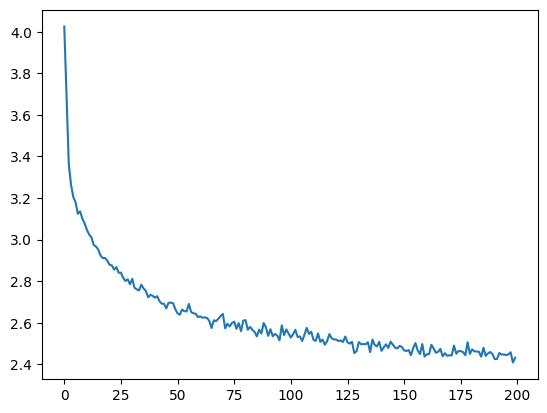

In [5]:
device = torch_device_setup()
all_categories, category_lines, n_categories = createCategoryDict()
hidden_size = 128

rnn = GenRNN(
    n_categories=n_categories,
    input_size=n_letters,
    hidden_size=hidden_size,
    output_size=n_letters,
)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0  # Reset every ``plot_every`` ``iters``

# Create optimizer once before training loop
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.0005)

start = time.time()

# blast through a load of randomly chosen samples
for itr in range(1, n_iters + 1):
    category_tensor, input_line_tensor, target_line_tensor = randomTrainingExample(
        all_categories, category_lines
    )
    output, loss = train_gen(
        rnn,
        category_tensor=category_tensor,
        input_line_tensor=input_line_tensor,
        target_line_tensor=target_line_tensor,
        optimizer=optimizer,
    )
    total_loss += loss

    if itr % print_every == 0:
        print("%s (%d %d%%) %.4f" % (timeSince(start), itr, itr / n_iters * 100, loss))

    if itr % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0


plt.figure()
plt.plot(all_losses)

In [ ]:
max_length = 20


# Sample from a category and starting letter
def sample(category, first_char_temperature=0.5):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(all_categories, category)
        inpt = inputTensor()
        hidden = rnn.initHidden()

        output_name = ""

        for i in range(max_length):
            output, hidden = rnn(category_tensor, inpt[-1], hidden)
            
            if i == 0:
                # Temperature sampling for first character only
                probs = torch.exp(output / first_char_temperature)
                probs[:, n_letters - 2] = 0  # zero out SOS probability
                topi = torch.multinomial(probs, 1)[0][0]
            else:
                # Greedy decoding for subsequent characters
                topv, topi = output.topk(1)
                topi = topi[0][0]
            
            if topi == n_letters - 1:  # break if it is EOS
                break

            letter = all_letters[topi]
            output_name += letter
            inpt = inputTensor(letter)

        return output_name


# Get multiple samples
def samples(category, quantity=3, first_char_temperature=0.5):
    print(f"{category}\n---")
    for _ in range(quantity):
        print(sample(category, first_char_temperature=first_char_temperature))
    print("")


samples("English")
samples("Spanish")
samples("Russian")
samples("German")
samples("Chinese")